In [3]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *

In [70]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36955 instead
  f"Port {expected} is already in use.\n"


In [72]:
client

<Client: 'tcp://128.117.208.84:46681' processes=7 threads=7, memory=130.41 GiB>

### validating pbmean in the fullgrid

In [9]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    return xa


In [10]:
# calculate average TBOT and PREC from the h0 tapes
# PREC=RAIN+SNOW
# use the last 30 years
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-360:]

tmp=xr.open_dataset(files[0])
lah0=tmp.area*tmp.landfrac

def preprocess(ds):
    dvs=['TLAI','GPP','TBOT','RAIN','SNOW']
    return ds[dvs]

ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess,decode_times=False)
ds['time']=xr.cftime_range('1985',periods=360,freq='MS')

In [11]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

ny = 30
tbot = 1/365/ny*(month_wts(ny)*ds.TBOT).sum(dim='time').compute()-273.15  #degC
gpp=(24*60*60*month_wts(ny)*ds.GPP).groupby('time.year').sum().mean(dim='year').compute() #gC/m2/yr
rain = 24*60*60/10*(month_wts(ny)*ds.RAIN).groupby('time.year').sum().mean(dim='year').compute()  #cm/yr
snow = 24*60*60/10*(month_wts(ny)*ds.SNOW).groupby('time.year').sum().mean(dim='year').compute()  #cm/yr
prec = rain+snow

In [12]:
### Readin 'h1' tape
def preprocess(ds):
    dvs=['TLAI','GPP','pfts1d_ixy','pfts1d_jxy','pfts1d_itype_veg','area','landfrac','pfts1d_wtgcell']
    return ds[dvs]

d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))[-360:]

ds_h1=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess,decode_times=False)
ds_h1['time']=xr.cftime_range('1985',periods=360,freq='MS')

In [13]:
# pfts1d_ixy and pfts1d_jxy will be useful, 
# but make sure to subtract 1 for pythonic indexing
# I think these change in time (but we aren't taking that into account)
tmp=xr.open_dataset(files[0])

lon_id = (tmp.pfts1d_ixy-1).astype('int')
lat_id = (tmp.pfts1d_jxy-1).astype('int')

In [14]:
# paste those climatologies into h1-shaped vectors
ta_h1 = xr.DataArray([tbot.isel(lat=j,lon=i) for i,j in zip(lon_id,lat_id)],dims='pft')
pr_h1 = xr.DataArray([prec.isel(lat=j,lon=i) for i,j in zip(lon_id,lat_id)],dims='pft')

In [15]:
# also calculate the GPP climatology (directly from h1)
# I use this for differentiating icesheets from tundra biome
gpp_clim_h1 = amean(ds_h1.GPP).mean(dim='year').compute()

#### assign biome

In [16]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [17]:
# assign a biome value for each 
# this is a bit tricky, see whittaker.ipynb
import geopandas as gpd
from shapely.geometry import *

fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
og   = data.biome_id.copy(deep=True).values
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order


bclass = np.zeros(len(ta_h1))+np.nan
for i in range(len(ta_h1)):
    if (ta_h1[i]<0)&(gpp_clim_h1[i]==0):
        bclass[i]=0  #ice
    else:
        ptf = gpd.GeoDataFrame({'geometry':[Point(ta_h1[i],pr_h1[i])]})
        x=gpd.overlay(ptf, data, how='intersection')
        if len(x)>0:
            bclass[i] = x.biome_id.values
        else:
            bclass[i] = byhand(ta_h1[i],pr_h1[i])


(array([51845.,  2923., 17459., 13731.,   441.,  9645., 11216.,  4986.,
         4730.,  1830.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

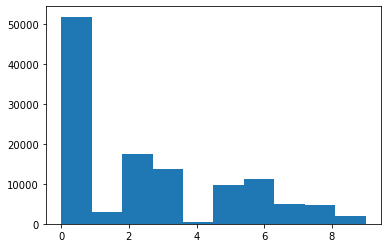

In [18]:
plt.hist(bclass)

In [19]:
# create the pxb vector
pxb = tmp.pfts1d_itype_veg*10+bclass

In [101]:
# create the appropriate landarea vector
# la = area*landfrac*pfts1d_wtgcell
# pfts1d_wtgcell varies by year
# read it in for the full climatology and then average

# paste land area into h1-shaped vector
h1_area = amean(ds_h1.area)
h1_landfrac = amean(ds_h1.landfrac)
a = h1_area * h1_landfrac

area = xr.DataArray([a.isel(lat=j,lon=i) for i,j in zip(lon_id,lat_id)],dims=('pft','year')).compute()

w = amean(ds_h1.pfts1d_wtgcell)
lah1 = area * w

In [44]:
pft_la = lah1.mean(dim='year').compute()

In [45]:
da = amean(ds_h1.TLAI).mean(dim='year').compute()

In [46]:
# finally we can do a pxbmean via:
fg_pbTLAI = 1/pft_la.groupby(pxb).sum()*(pft_la*da).groupby(pxb).sum()

### Sparse grid

In [73]:
# sparsegrid
LHC_h1=get_exp('transient',dvs=['TLAI'],tape='h1',yy=(1985,2014))

In [93]:
sg_tlai=amean(LHC_h1.TLAI.isel(ens=0)).mean(dim='year').compute()

In [103]:
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
dapb=pbmean(sg_tlai,a)
sg_pbTLAI = dapb.mean(dim='year')

ValueError: cannot reindex or align along dimension 'pft' because the index has duplicate values

In [ ]:
### Plot sparsegrid versus fullgrid evaluation
df=pd.DataFrame({'FG':fg_pbTLAI,'SG':sg_pbTLAI})
df.plot(kind='barh',figsize=[10,7]);
plt.xlabel('PxB TLAI (m2/m2)')
plt.yticks(range(16),pfts[:16]);

### pbmean function for the sparsegrid

In [102]:
#read in biome vector and pft vector
whit=xr.open_dataset('whit/whitkey.nc')
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
pft=ds.pfts1d_itype_veg

#define the pft-x-biome group
pftbiome=xr.DataArray(np.zeros(ds.pft.shape)+np.nan,dims='pft',name='pb')
for i in range(1,17):
    pftbiome[pft==i]=whit.biome+10*i

def pbmean(da,a,minarea=5e4):
    asum=a.groupby(pftbiome).sum()
    asum=asum.where(asum>minarea)
    dapb=1/asum*(a*da).groupby(pftbiome).sum().compute()
    
    #append useful labels
    pb=dapb.pb
    #dapb['pft']  =np.floor(pb/10).astype(int)
    dapb['biome']=(pb-10*dapb.pft).astype(int)
    
    return dapb

### testing function

In [58]:
#read in dummy data
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
ds['time']=xr.cftime_range('2005',periods=120,freq='MS',calendar='noleap')
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft

In [63]:
#note that lapft has a time dimension in the transient cases
#your area vector must comply with your data array in the time dimension
#e.g., if you use annualized lai, you must annualize lapft
lai=ds.TLAI.groupby('time.year').mean().compute()
a=lapft.groupby('time.year').mean()
dapb=pbmean(lai,a)

In [64]:
p=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC0000.nc')
pftnames=[str(p.pftname[i].values)[2:-1].strip() for i in range(17)]

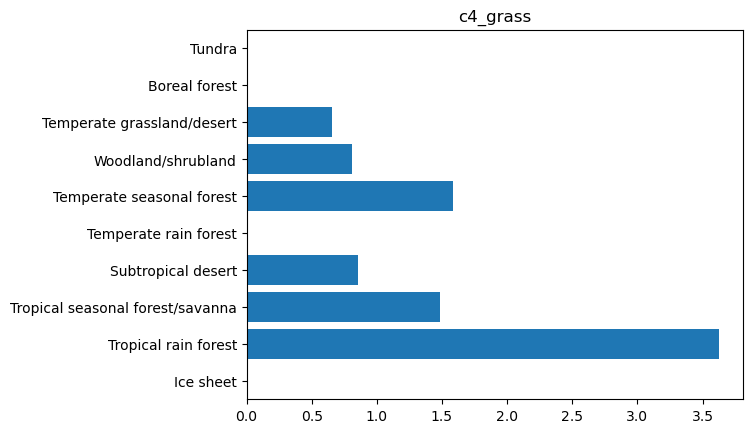

In [65]:
pft=14
plt.barh(range(10),dapb.mean(dim='year').isel(pb=dapb.pft==pft))
plt.yticks(range(10),whit.biome_name.values)
plt.ylim([-0.5,9.5]);
plt.title(pftnames[pft]);

In [56]:
print('hello world')

hello world
